In [1]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))

def calc_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'] + df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

def preprocessor_book(file_path):
    
    df = pd.read_csv(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # new feats
    df['dom'] = calc_dom(df)  
    
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    
    #df['wap_mean'] = df['wap'].transform('mean')
    #df['market_mean'] = df['wap'].mean()
    #df['market_mean_seconds'] = df.groupby(['seconds_in_bucket'])['wap'].transform('mean')
    
    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean, np.std],
        'price_spread':[np.mean, np.std],
        'bid_spread':[np.mean, np.std],
        'ask_spread':[np.mean, np.std],
        'volume_imbalance':[np.mean, np.std],
        'total_volume':[np.mean, np.std],
        'wap':[np.mean, np.std],
        'dom':[np.mean, np.std],
        'bid_ask_spread1':[np.mean, np.std],
        'bid_ask_spread2':[np.mean, np.std]
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()

    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
            
    #create row_id
    stock_id = file_path.split('/')[1].split('_')[1].split('.')[0]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)

    return df_feature

In [3]:
file_path = "individual_book_train/stock_0.csv"

preprocessor_book(file_path)

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,total_volume_std_300,wap_mean_300,wap_std_300,dom_mean_300,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id
0,0.004499,0.006999,0.000388,0.000295,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,136.527199,1.003753,0.000487,296.067006,137.087390,0.000822,0.000237,0.001207,0.000214,0-5
1,0.001204,0.002476,0.000212,0.000155,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,168.586713,1.000397,0.000207,484.668169,168.659966,0.000353,0.000121,0.000640,0.000175,0-11
2,0.002369,0.004801,0.000331,0.000246,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,120.920736,0.998685,0.000779,454.726596,120.762809,0.000689,0.000162,0.001081,0.000321,0-16
3,0.002574,0.003637,0.000380,0.000248,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,146.485459,0.998436,0.000504,417.560601,146.251758,0.000834,0.000278,0.001087,0.000316,0-31
4,0.001895,0.003257,0.000254,0.000188,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,165.851509,0.999488,0.000205,407.366345,165.800234,0.000425,0.000140,0.000737,0.000174,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.002579,0.003821,0.000212,0.000159,0.000552,0.000202,0.000083,0.000072,-0.000182,0.000125,...,142.775530,0.997519,0.000830,349.745242,142.496468,0.000509,0.000150,0.000740,0.000153,0-32751
3826,0.002206,0.002847,0.000267,0.000193,0.000542,0.000147,0.000092,0.000088,-0.000172,0.000083,...,264.869952,1.000681,0.000439,669.124097,264.965226,0.000588,0.000118,0.000839,0.000112,0-32753
3827,0.002913,0.003266,0.000237,0.000188,0.000525,0.000244,0.000202,0.000147,-0.000083,0.000060,...,124.014444,1.000111,0.000454,326.814501,124.029975,0.000446,0.000177,0.000712,0.000255,0-32758
3828,0.003046,0.005105,0.000245,0.000187,0.000480,0.000145,0.000113,0.000104,-0.000166,0.000149,...,154.066273,1.002277,0.000239,395.502642,154.466720,0.000516,0.000124,0.000786,0.000207,0-32763


In [4]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = "individual_book_train/stock_" + str(stock_id) + ".csv"
            #file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = "individual_book_train/stock_" + str(stock_id) + ".csv"
            #file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = preprocessor_book(file_path_book)
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.7s finished


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,total_volume_std_300,wap_mean_300,wap_std_300,dom_mean_300,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id
0,0.004499,0.006999,0.000388,0.000295,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,136.527199,1.003753,0.000487,296.067006,137.087390,0.000822,0.000237,0.001207,0.000214,0-5
1,0.001204,0.002476,0.000212,0.000155,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,168.586713,1.000397,0.000207,484.668169,168.659966,0.000353,0.000121,0.000640,0.000175,0-11
2,0.002369,0.004801,0.000331,0.000246,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,120.920736,0.998685,0.000779,454.726596,120.762809,0.000689,0.000162,0.001081,0.000321,0-16
3,0.002574,0.003637,0.000380,0.000248,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,146.485459,0.998436,0.000504,417.560601,146.251758,0.000834,0.000278,0.001087,0.000316,0-31
4,0.001895,0.003257,0.000254,0.000188,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,165.851509,0.999488,0.000205,407.366345,165.800234,0.000425,0.000140,0.000737,0.000174,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,0.003723,0.004996,0.000330,0.000262,0.000597,0.000154,0.000157,0.000118,-0.000118,0.000078,...,143.079814,1.000130,0.000284,322.334721,143.089713,0.000617,0.000152,0.000886,0.000177,1-32751
7656,0.010829,0.012168,0.000403,0.000333,0.000922,0.000333,0.000159,0.000120,-0.000125,0.000087,...,253.846278,1.012343,0.001410,491.272698,257.047480,0.001082,0.000326,0.001404,0.000323,1-32753
7657,0.003135,0.004268,0.000243,0.000168,0.000648,0.000150,0.000141,0.000064,-0.000132,0.000070,...,142.164742,1.001250,0.000243,427.424687,142.323321,0.000625,0.000136,0.000918,0.000120,1-32758
7658,0.003750,0.005773,0.000199,0.000155,0.000421,0.000201,0.000190,0.000100,-0.000231,0.000153,...,174.539672,1.004296,0.000569,521.331553,175.331803,0.000410,0.000173,0.000814,0.000257,1-32763


In [5]:
#!pip install pyarrow
#!pip install fastparquet
pd.io.parquet.get_engine('auto')

In [6]:
stock_ids = pd.read_csv("all_times.csv").stock_id.unique()

n = len(stock_ids)

train_ids = stock_ids[0:7*(n//10)] # 98 stock_ids
test_ids = stock_ids[7*(n//10):]

In [7]:
len(train_ids)

77

In [8]:
len(test_ids)

35

In [9]:
df_train = preprocessor(list_stock_ids=train_ids, is_train=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  1.1min finished


In [10]:
beta_df = pd.read_csv("all_times.csv")
#beta[beta.time_id == 5][beta.stock_id == 0].beta

df_train['beta'] = beta_df.beta
df_train = df_train.fillna(0)

In [11]:
df_train

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,wap_mean_300,wap_std_300,dom_mean_300,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id,beta
0,0.004499,0.006999,0.000388,0.000295,0.000852,2.113443e-04,0.000176,1.624440e-04,-0.000151,1.261549e-04,...,1.003753,0.000487,296.067006,137.087390,0.000822,2.372347e-04,0.001207,2.140140e-04,0-5,1.208072
1,0.001204,0.002476,0.000212,0.000155,0.000394,1.571616e-04,0.000142,1.482799e-04,-0.000135,6.490351e-05,...,1.000397,0.000207,484.668169,168.659966,0.000353,1.209375e-04,0.000640,1.748483e-04,0-11,0.647253
2,0.002369,0.004801,0.000331,0.000246,0.000725,1.635371e-04,0.000197,1.701960e-04,-0.000198,1.710729e-04,...,0.998685,0.000779,454.726596,120.762809,0.000689,1.622458e-04,0.001081,3.211575e-04,0-16,2.101981
3,0.002574,0.003637,0.000380,0.000248,0.000860,2.799896e-04,0.000190,1.994161e-04,-0.000108,9.106954e-05,...,0.998436,0.000504,417.560601,146.251758,0.000834,2.779917e-04,0.001087,3.158835e-04,0-31,-1.888512
4,0.001895,0.003257,0.000254,0.000188,0.000397,1.300102e-04,0.000191,8.299167e-05,-0.000109,7.604577e-05,...,0.999488,0.000205,407.366345,165.800234,0.000425,1.402238e-04,0.000737,1.743748e-04,0-62,-0.597581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294878,0.002856,0.003479,0.000102,0.000078,0.000240,9.118216e-05,0.000177,2.734540e-05,-0.000173,4.315351e-08,...,0.994631,0.000539,1339.929375,280.893953,0.000246,9.391521e-05,0.000602,1.021393e-04,86-32751,0.000000
294879,0.003425,0.004707,0.000195,0.000145,0.000414,1.724008e-04,0.000180,5.674844e-05,-0.000202,8.229088e-05,...,0.996409,0.001366,1407.954891,701.905120,0.000484,1.829352e-04,0.000879,2.027752e-04,86-32753,0.000000
294880,0.001839,0.002357,0.000114,0.000083,0.000269,1.057722e-04,0.000191,3.692326e-05,-0.000188,4.366354e-08,...,1.000096,0.000395,1377.954496,282.282520,0.000256,1.004806e-04,0.000632,1.005726e-04,86-32758,0.000000
294881,0.001741,0.002388,0.000077,0.000059,0.000252,1.672871e-07,0.000252,4.408465e-08,-0.000252,4.852174e-08,...,1.000460,0.000356,7670.512893,1324.085592,0.000252,9.713833e-08,0.000755,3.135416e-07,86-32763,0.000000


In [12]:
df_train['target'] = df_train['log_return_realized_volatility']
df_train

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,wap_std_300,dom_mean_300,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id,beta,target
0,0.004499,0.006999,0.000388,0.000295,0.000852,2.113443e-04,0.000176,1.624440e-04,-0.000151,1.261549e-04,...,0.000487,296.067006,137.087390,0.000822,2.372347e-04,0.001207,2.140140e-04,0-5,1.208072,0.004499
1,0.001204,0.002476,0.000212,0.000155,0.000394,1.571616e-04,0.000142,1.482799e-04,-0.000135,6.490351e-05,...,0.000207,484.668169,168.659966,0.000353,1.209375e-04,0.000640,1.748483e-04,0-11,0.647253,0.001204
2,0.002369,0.004801,0.000331,0.000246,0.000725,1.635371e-04,0.000197,1.701960e-04,-0.000198,1.710729e-04,...,0.000779,454.726596,120.762809,0.000689,1.622458e-04,0.001081,3.211575e-04,0-16,2.101981,0.002369
3,0.002574,0.003637,0.000380,0.000248,0.000860,2.799896e-04,0.000190,1.994161e-04,-0.000108,9.106954e-05,...,0.000504,417.560601,146.251758,0.000834,2.779917e-04,0.001087,3.158835e-04,0-31,-1.888512,0.002574
4,0.001895,0.003257,0.000254,0.000188,0.000397,1.300102e-04,0.000191,8.299167e-05,-0.000109,7.604577e-05,...,0.000205,407.366345,165.800234,0.000425,1.402238e-04,0.000737,1.743748e-04,0-62,-0.597581,0.001895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294878,0.002856,0.003479,0.000102,0.000078,0.000240,9.118216e-05,0.000177,2.734540e-05,-0.000173,4.315351e-08,...,0.000539,1339.929375,280.893953,0.000246,9.391521e-05,0.000602,1.021393e-04,86-32751,0.000000,0.002856
294879,0.003425,0.004707,0.000195,0.000145,0.000414,1.724008e-04,0.000180,5.674844e-05,-0.000202,8.229088e-05,...,0.001366,1407.954891,701.905120,0.000484,1.829352e-04,0.000879,2.027752e-04,86-32753,0.000000,0.003425
294880,0.001839,0.002357,0.000114,0.000083,0.000269,1.057722e-04,0.000191,3.692326e-05,-0.000188,4.366354e-08,...,0.000395,1377.954496,282.282520,0.000256,1.004806e-04,0.000632,1.005726e-04,86-32758,0.000000,0.001839
294881,0.001741,0.002388,0.000077,0.000059,0.000252,1.672871e-07,0.000252,4.408465e-08,-0.000252,4.852174e-08,...,0.000356,7670.512893,1324.085592,0.000252,9.713833e-08,0.000755,3.135416e-07,86-32763,0.000000,0.001741


In [13]:
test_ids

array([ 87,  88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 118, 119, 120, 122, 123, 124, 125, 126], dtype=int64)

In [14]:
df_test = preprocessor(list_stock_ids=test_ids, is_train=False)

beta_df = pd.read_csv("all_times.csv")
#beta[beta.time_id == 5][beta.stock_id == 0].beta

df_test['beta'] = beta_df.beta
df_test = df_train.fillna(0)

df_test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   30.8s finished


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,wap_std_300,dom_mean_300,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id,beta,target
0,0.004499,0.006999,0.000388,0.000295,0.000852,2.113443e-04,0.000176,1.624440e-04,-0.000151,1.261549e-04,...,0.000487,296.067006,137.087390,0.000822,2.372347e-04,0.001207,2.140140e-04,0-5,1.208072,0.004499
1,0.001204,0.002476,0.000212,0.000155,0.000394,1.571616e-04,0.000142,1.482799e-04,-0.000135,6.490351e-05,...,0.000207,484.668169,168.659966,0.000353,1.209375e-04,0.000640,1.748483e-04,0-11,0.647253,0.001204
2,0.002369,0.004801,0.000331,0.000246,0.000725,1.635371e-04,0.000197,1.701960e-04,-0.000198,1.710729e-04,...,0.000779,454.726596,120.762809,0.000689,1.622458e-04,0.001081,3.211575e-04,0-16,2.101981,0.002369
3,0.002574,0.003637,0.000380,0.000248,0.000860,2.799896e-04,0.000190,1.994161e-04,-0.000108,9.106954e-05,...,0.000504,417.560601,146.251758,0.000834,2.779917e-04,0.001087,3.158835e-04,0-31,-1.888512,0.002574
4,0.001895,0.003257,0.000254,0.000188,0.000397,1.300102e-04,0.000191,8.299167e-05,-0.000109,7.604577e-05,...,0.000205,407.366345,165.800234,0.000425,1.402238e-04,0.000737,1.743748e-04,0-62,-0.597581,0.001895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294878,0.002856,0.003479,0.000102,0.000078,0.000240,9.118216e-05,0.000177,2.734540e-05,-0.000173,4.315351e-08,...,0.000539,1339.929375,280.893953,0.000246,9.391521e-05,0.000602,1.021393e-04,86-32751,0.000000,0.002856
294879,0.003425,0.004707,0.000195,0.000145,0.000414,1.724008e-04,0.000180,5.674844e-05,-0.000202,8.229088e-05,...,0.001366,1407.954891,701.905120,0.000484,1.829352e-04,0.000879,2.027752e-04,86-32753,0.000000,0.003425
294880,0.001839,0.002357,0.000114,0.000083,0.000269,1.057722e-04,0.000191,3.692326e-05,-0.000188,4.366354e-08,...,0.000395,1377.954496,282.282520,0.000256,1.004806e-04,0.000632,1.005726e-04,86-32758,0.000000,0.001839
294881,0.001741,0.002388,0.000077,0.000059,0.000252,1.672871e-07,0.000252,4.408465e-08,-0.000252,4.852174e-08,...,0.000356,7670.512893,1324.085592,0.000252,9.713833e-08,0.000755,3.135416e-07,86-32763,0.000000,0.001741


In [15]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)

for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()
    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
    
df_train['stock_id_target_enc'] = tmp

In [16]:
df_train

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id,beta,target,stock_id,stock_id_target_enc
0,0.004499,0.006999,0.000388,0.000295,0.000852,2.113443e-04,0.000176,1.624440e-04,-0.000151,1.261549e-04,...,137.087390,0.000822,2.372347e-04,0.001207,2.140140e-04,0-5,1.208072,0.004499,0,0.004450
1,0.001204,0.002476,0.000212,0.000155,0.000394,1.571616e-04,0.000142,1.482799e-04,-0.000135,6.490351e-05,...,168.659966,0.000353,1.209375e-04,0.000640,1.748483e-04,0-11,0.647253,0.001204,0,0.004466
2,0.002369,0.004801,0.000331,0.000246,0.000725,1.635371e-04,0.000197,1.701960e-04,-0.000198,1.710729e-04,...,120.762809,0.000689,1.622458e-04,0.001081,3.211575e-04,0-16,2.101981,0.002369,0,0.004429
3,0.002574,0.003637,0.000380,0.000248,0.000860,2.799896e-04,0.000190,1.994161e-04,-0.000108,9.106954e-05,...,146.251758,0.000834,2.779917e-04,0.001087,3.158835e-04,0-31,-1.888512,0.002574,0,0.004451
4,0.001895,0.003257,0.000254,0.000188,0.000397,1.300102e-04,0.000191,8.299167e-05,-0.000109,7.604577e-05,...,165.800234,0.000425,1.402238e-04,0.000737,1.743748e-04,0-62,-0.597581,0.001895,0,0.004467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294878,0.002856,0.003479,0.000102,0.000078,0.000240,9.118216e-05,0.000177,2.734540e-05,-0.000173,4.315351e-08,...,280.893953,0.000246,9.391521e-05,0.000602,1.021393e-04,86-32751,0.000000,0.002856,86,0.002948
294879,0.003425,0.004707,0.000195,0.000145,0.000414,1.724008e-04,0.000180,5.674844e-05,-0.000202,8.229088e-05,...,701.905120,0.000484,1.829352e-04,0.000879,2.027752e-04,86-32753,0.000000,0.003425,86,0.002948
294880,0.001839,0.002357,0.000114,0.000083,0.000269,1.057722e-04,0.000191,3.692326e-05,-0.000188,4.366354e-08,...,282.282520,0.000256,1.004806e-04,0.000632,1.005726e-04,86-32758,0.000000,0.001839,86,0.002948
294881,0.001741,0.002388,0.000077,0.000059,0.000252,1.672871e-07,0.000252,4.408465e-08,-0.000252,4.852174e-08,...,1324.085592,0.000252,9.713833e-08,0.000755,3.135416e-07,86-32763,0.000000,0.001741,86,0.002966


In [17]:
df_test

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,dom_std_300,bid_ask_spread1_mean_300,bid_ask_spread1_std_300,bid_ask_spread2_mean_300,bid_ask_spread2_std_300,row_id,beta,target,stock_id,stock_id_target_enc
0,0.004499,0.006999,0.000388,0.000295,0.000852,2.113443e-04,0.000176,1.624440e-04,-0.000151,1.261549e-04,...,137.087390,0.000822,2.372347e-04,0.001207,2.140140e-04,0-5,1.208072,0.004499,0,0.004459
1,0.001204,0.002476,0.000212,0.000155,0.000394,1.571616e-04,0.000142,1.482799e-04,-0.000135,6.490351e-05,...,168.659966,0.000353,1.209375e-04,0.000640,1.748483e-04,0-11,0.647253,0.001204,0,0.004459
2,0.002369,0.004801,0.000331,0.000246,0.000725,1.635371e-04,0.000197,1.701960e-04,-0.000198,1.710729e-04,...,120.762809,0.000689,1.622458e-04,0.001081,3.211575e-04,0-16,2.101981,0.002369,0,0.004459
3,0.002574,0.003637,0.000380,0.000248,0.000860,2.799896e-04,0.000190,1.994161e-04,-0.000108,9.106954e-05,...,146.251758,0.000834,2.779917e-04,0.001087,3.158835e-04,0-31,-1.888512,0.002574,0,0.004459
4,0.001895,0.003257,0.000254,0.000188,0.000397,1.300102e-04,0.000191,8.299167e-05,-0.000109,7.604577e-05,...,165.800234,0.000425,1.402238e-04,0.000737,1.743748e-04,0-62,-0.597581,0.001895,0,0.004459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294878,0.002856,0.003479,0.000102,0.000078,0.000240,9.118216e-05,0.000177,2.734540e-05,-0.000173,4.315351e-08,...,280.893953,0.000246,9.391521e-05,0.000602,1.021393e-04,86-32751,0.000000,0.002856,86,0.002956
294879,0.003425,0.004707,0.000195,0.000145,0.000414,1.724008e-04,0.000180,5.674844e-05,-0.000202,8.229088e-05,...,701.905120,0.000484,1.829352e-04,0.000879,2.027752e-04,86-32753,0.000000,0.003425,86,0.002956
294880,0.001839,0.002357,0.000114,0.000083,0.000269,1.057722e-04,0.000191,3.692326e-05,-0.000188,4.366354e-08,...,282.282520,0.000256,1.004806e-04,0.000632,1.005726e-04,86-32758,0.000000,0.001839,86,0.002956
294881,0.001741,0.002388,0.000077,0.000059,0.000252,1.672871e-07,0.000252,4.408465e-08,-0.000252,4.852174e-08,...,1324.085592,0.000252,9.713833e-08,0.000755,3.135416e-07,86-32763,0.000000,0.001741,86,0.002956


In [18]:
import lightgbm as lgbm
import matplotlib.pyplot as plt

# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [19]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [20]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

## CV

In [21]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [22]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if True:    
        
        feature_names = X_train.columns.values.tolist()
        
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11808
[LightGBM] [Info] Number of data points in the train set: 235906, number of used features: 47
[LightGBM] [Info] Start training from score 0.001773
Training until validation scores don't improve for 30 rounds


C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's rmse: 0.000462558	training's RMSPE: 0.21404	valid_1's rmse: 0.000463769	valid_1's RMSPE: 0.21377
[200]	training's rmse: 0.000178752	training's RMSPE: 0.08271	valid_1's rmse: 0.000179927	valid_1's RMSPE: 0.08294
[300]	training's rmse: 7.98545e-05	training's RMSPE: 0.03695	valid_1's rmse: 8.13879e-05	valid_1's RMSPE: 0.03751
[400]	training's rmse: 4.90763e-05	training's RMSPE: 0.02271	valid_1's rmse: 5.10806e-05	valid_1's RMSPE: 0.02355
[500]	training's rmse: 3.9415e-05	training's RMSPE: 0.01824	valid_1's rmse: 4.17711e-05	valid_1's RMSPE: 0.01925
[600]	training's rmse: 3.54125e-05	training's RMSPE: 0.01639	valid_1's rmse: 3.82475e-05	valid_1's RMSPE: 0.01763
[700]	training's rmse: 3.31346e-05	training's RMSPE: 0.01533	valid_1's rmse: 3.6481e-05	valid_1's RMSPE: 0.01682
[800]	training's rmse: 3.14651e-05	training's RMSPE: 0.01456	valid_1's rmse: 3.54957e-05	valid_1's RMSPE: 0.01636
[900]	training's rmse: 3.01878e-05	training's RMSPE: 0.01397	valid_1's rmse: 3.49121e-05	v

[800]	training's rmse: 3.12935e-05	training's RMSPE: 0.01449	valid_1's rmse: 3.61041e-05	valid_1's RMSPE: 0.01661
[900]	training's rmse: 3.00251e-05	training's RMSPE: 0.0139	valid_1's rmse: 3.56976e-05	valid_1's RMSPE: 0.01642
[1000]	training's rmse: 2.90018e-05	training's RMSPE: 0.01343	valid_1's rmse: 3.53929e-05	valid_1's RMSPE: 0.01628
[1100]	training's rmse: 2.81503e-05	training's RMSPE: 0.01303	valid_1's rmse: 3.51682e-05	valid_1's RMSPE: 0.01618
[1200]	training's rmse: 2.73973e-05	training's RMSPE: 0.01268	valid_1's rmse: 3.50191e-05	valid_1's RMSPE: 0.01611
[1300]	training's rmse: 2.67062e-05	training's RMSPE: 0.01236	valid_1's rmse: 3.48725e-05	valid_1's RMSPE: 0.01604
[1400]	training's rmse: 2.61171e-05	training's RMSPE: 0.01209	valid_1's rmse: 3.47258e-05	valid_1's RMSPE: 0.01598
Early stopping, best iteration is:
[1389]	training's rmse: 2.61777e-05	training's RMSPE: 0.01212	valid_1's rmse: 3.47235e-05	valid_1's RMSPE: 0.01597
Performance of the　prediction: , RMSPE: 0.016
**

In [23]:
scores

0.016399999999999998

In [24]:
gain_importance_df.sort_values(['importance'], ascending=False)

,importance
log_return_realized_volatility,3.138900e+06
log_return_realized_volatility_300,6.086682e+05
log_return2_realized_volatility,6.660496e+04
log_return2_realized_volatility_300,3.887272e+04
wap_std,1.064144e+03
ask_spread_mean,7.437551e+02
stock_id,6.954292e+02
price_spread_std,2.712094e+02
price_spread_mean,2.063837e+02
wap_balance_mean_300,1.721758e+02


array([[<AxesSubplot:title={'center':'importance'}>]], dtype=object)

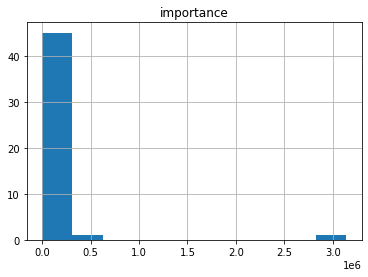

In [25]:
gain_importance_df.hist()

In [26]:
split_importance_df.sort_values(['importance'], ascending=False)

,importance
log_return_realized_volatility,10816
log_return_realized_volatility_300,5143
log_return2_realized_volatility_300,2939
log_return2_realized_volatility,2565
wap_std,533
stock_id,481
wap_balance_mean_300,404
wap_balance_std,335
price_spread_std,238
wap_mean,223


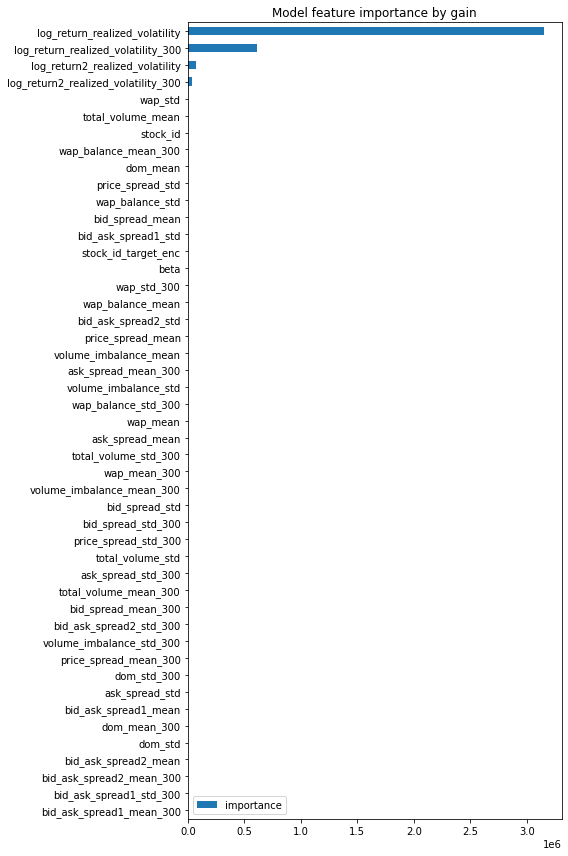

,feature_names,importance
0,bid_ask_spread1_mean_300,1.919350e+00
1,bid_ask_spread1_std_300,3.674991e+00
2,bid_ask_spread2_mean_300,4.755258e+00
3,bid_ask_spread2_mean,6.025814e+00
4,dom_std,7.870095e+00
5,dom_mean_300,8.784671e+00
6,bid_ask_spread1_mean,1.044004e+01
7,ask_spread_std,1.172110e+01
8,dom_std_300,1.248136e+01
9,price_spread_mean_300,1.451385e+01


In [27]:
import matplotlib

def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('gain_importance_mean.csv', index=False)
    
mean_gain_df

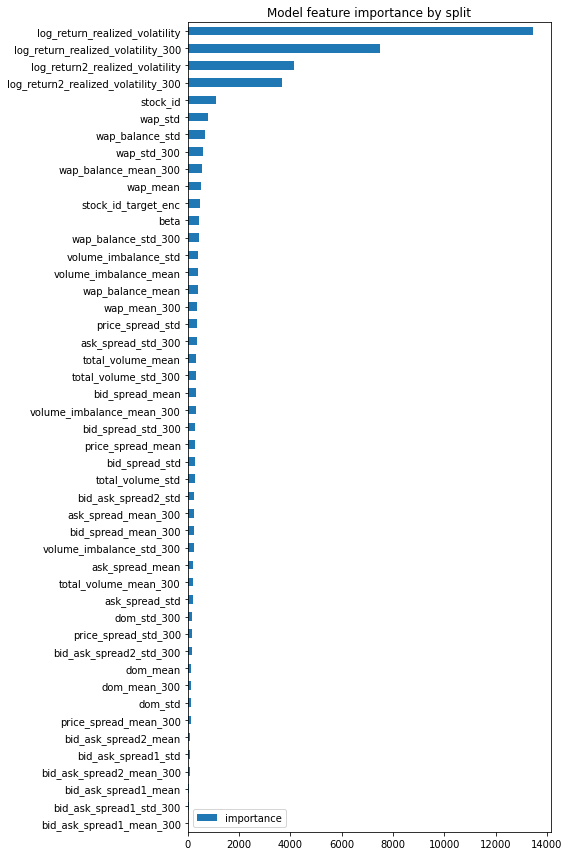

In [28]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('split_importance_mean.csv', index=False)

## Test

In [29]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['row_id'], axis = 1)

In [30]:
target = np.zeros(len(X_test))

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [31]:
y_pred = y_pred.assign(target = target)
y_pred

,row_id,target
0,0-5,0.004481
1,0-11,0.001223
2,0-16,0.002351
3,0-31,0.002571
4,0-62,0.001900
...,...,...
294878,86-32751,0.002849
294879,86-32753,0.003436
294880,86-32758,0.001838
294881,86-32763,0.001740
